# 소비자 데이터 기반 소비 예측 경진대회 두 번째 베이스라인

이번 대회는 소비자 데이터를 통하여 소비량을 예측하는 대회입니다.

모델을 작성해서 성능을 확인해보고 앙상블 기법에 따라서 어떻게 성능이 변하고 어떻게 접근해야 하는지 알아봅시다!

그럼 시작해볼까요?

## 패키지 설치
필요한 패키지들을 설치합니다.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## 데이터 불러오기

In [2]:
#csv 형식의 training 데이터를 로드합니다.
train = pd.read_csv('data/train.csv')
#데이터 살펴보기 위해 데이터 최상단의 5줄을 표시합니다.
train.head() 

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


## 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [4]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


이번 데이터는 결측치가 존재하지 않네요!

## 데이터 전처리

### 일자 분리
모델에 수치를 넣고 학습시키기 위해선 글자나 문자를 숫자로 바꿔주는 작업이 필요합니다.

주어진 데이터를 살펴보면 Dt_Customer 문자열(string)로 되어있는 것을 확인하실 수 있습니다.

이를 각각 년도, 월, 일로 나누어 숫자형으로 변환해 보겠습니다.

In [6]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,10,6,2014


년도, 월, 일이 전부 잘 분리되어 들어간게 보이시나요?

이제 사용이 필요 없어진 중복된 Dt_Customer 열을 삭제해주겠습니다.

In [7]:
train = train.drop('Dt_Customer', axis = 1)
train.shape ## (행, 열)

(1108, 24)

### 카테고리형 데이터 인코딩

1차로 제공해드린 베이스라인에서 진행했던 것 처럼,

'Label Encoding' 을 통해서 카테고리형을 숫자 값으로 변환해보겠습니다.

우리 데이터에는 Education와 Marital_Status 피쳐가 문자로 이루어져있기 때문에, 이것을 Label Encoding을 통해 숫자형으로 표현해보겠습니다.

In [9]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,10,6,2014


## 변수 및 모델 정의

이제 본격적으로 모델을 설계하기 위해 데이터를 독립변수(X)와 종속변수(y) 로 나누어 줍니다

우리의 목적은 주어진 소비자 데이터를 이용하여 사람들이 얼마나 소비를 하는지 소비량(Target)을 예측하는 것입니다.

그럼 소비 데이터가 X, 소비량이 y가 되겠죠?

In [10]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 소비량 추출

첫번째 베이스라인에서 한 것처럼, 모델이 적합한지 검증을 하기 위하여   
train 셋에서 학습시킬 셋 train_data와 검증할 셋 val_data를 만들어 보겠습니다.     
train 셋에서 70%를 학습을 시키는데 쓰고, 나머지 30%를 모델이 유의미한지 검증하도록 나누겠습니다.

In [16]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.3) #30프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

In [17]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (775, 24)
검증할 val 셋 :  (333, 24)


위의 데이터 모양을 보면, 775개의 데이터를 학습시켜 333개의 데이터로 성능을 검증시킬 것 입니다!

In [18]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 소비량 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #training 데이터에서 소비량 추출

## 다양한 모델 선언과 학습

먼저, 첫번째 베이스라인에서 는단순한 선형회귀 모델에 대해서 알아보았습니다.

이번에는 선형회귀 모델을 비롯하여 대표적인 ML모델의 하나인 RandomForest, GradientBoosting 모델을 같이 이용하여 좀 더 다양하게 학습을 시켜보겠습니다.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=0.06, criterion='mae', random_state=32))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_data_X, train_data_y)

In [24]:
print(models) ## 사용된 모델 확인

[LinearRegression(), RandomForestRegressor(random_state=32), GradientBoostingRegressor(criterion='mae', learning_rate=0.06, random_state=32)]


## 앙상블 추론 (Inference)

이번 베이스라인에서는 단일 모델에서 나오는 성능의 결과를 기대하는 것이 아니라,

여러 개의 단일 모델들의 평균치를 내거나(Soft-Voting), 투표를 해서 다수결에 의한 결정(Hard-Voting)을 하는 등

여러 모델들의 '집단 지성'을 활용하여 더 나은 결과를 도출해 내는 것에 목적이 있습니다.

즉, 앙상블을 통하여 다중 학습 모델을 기반으로 분산 또는 편향의 감소를 통해 전체 에러를 줄이는 것입니다.

### Ensemble (앙상블) 기법

앙상블 기법에는 다양한 방법이 있습니다.

Voting (투표) : 투표를 통해 결과 도출    
Bagging : 샘플을 다양하게 중복 생성    
Boosting : 이전 오차를 보완하며 가중치 부여   
Stacking : 여러 모델을 기반으로 meta 모델 생성   
이와 같은 다양한 방법 중에서 이번 베이스라인에서는 앙상블 기법 중 **Voting**을 사용할 것입니다.

### Voting (투표)
Voting은 단어 뜻 그대로 투표를 통해 결정하는 방식입니다.   
**Voting**은 **Bagging**과 투표방식이라는 점에서 유사하지만, 다음과 같은 큰 차이점이 있습니다.

* Voting은 다른 알고리즘 모델을 조합해서 사용합니다.
* Bagging은 같은 알고리즘 내에서 다른 sample 조합을 사용합니다.

즉, Voting은 서로 다른 알고리즘이 도출해 낸 결과물에 대하여 최종 투표하는 방식을 통해 최종 결과를 선택합니다.  

<br>

Voting은 또 **Hard Voting**과 **Soft Voting**으로 나뉘게 됩니다.

* Hard Voting : 각 모델들의 결과물에 대한 최종 값을 투표를 해서 결정합니다.
* Soft Voting : 각 모델들의 결과물이 나올 확률 값이나 회귀 값을 평균을 내서 최종 값을 도출합니다.

정리하자면, 이번 베이스라인에서는 앙상블(Ensemble) 기법 중에서 **Soft-Voting**을 사용하여 더 나은 결과값을 도출해보겠습니다.

## Soft-Voting 구현

이전에 학습시킨 3개의 모델들을 각각 추론하고,   
추론 결과들을 Soft-Voting 방식으로 결합하는 것을 간단하게 직접 구현해보겠습니다.

In [21]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(val_data_X)
    else:
        prediction += model.predict(val_data_X)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

모델이 실제로 데이터를 얼마나 잘 맞추는지 확인해볼까요?

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.23535309071441088


NMAE로 계산하여 0.235가 나왔습니다.

NMAE 0.235는 대략 예측치와 실제값이 23.5% 정도의 오차율을 보인다는 것을 의미합니다.

선형회귀만을 사용한 첫번째 베이스라인 0.281에서,

앙상블 기법을 활용하여 0.235 오차 까지 낮춘 것을 확인 할 수 있었습니다.

## 예측값 눈으로 확인하기

그러면, 0.235라는 숫자만 봐서는 모델이 어떤방식으로 맞췄는지 어디에서 오차가 더 많이 나는지 알 수 없으므로,

plot을 그려서 예측값의 분포를 확인해 보겠습니다.

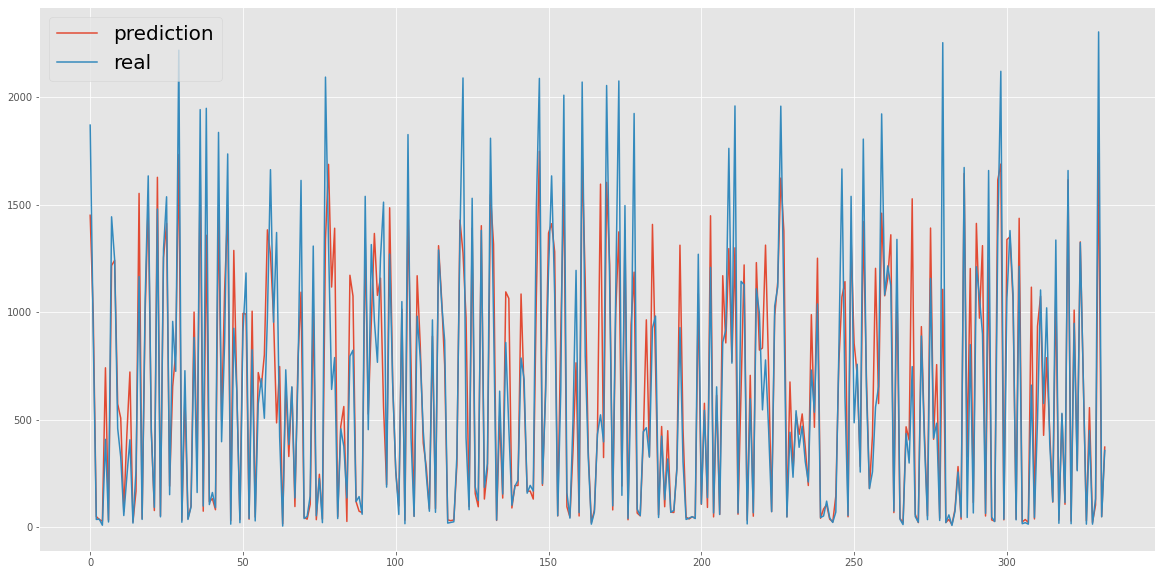

In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 9))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

파란선이 실제 따릉이 소비량, 붉은 선이 우리의 모델이 예측한 값입니다.

여러분이 보기에는 어떠신가요

우리의 모델이 어느정도 예측을 하고 있는 것 같은가요?

## train 셋 + val 셋 100% 활용하는 모델 만들기

이제 검증 셋으로 성능이 유의미한지 확인을 하였다면 데이터를 100% 활용하기 위하여   
검증 셋을 포함한 train 셋을 만들어보겠습니다.

In [25]:
train_X = train.drop(['target', 'id'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 소비량 추출

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=0.06, criterion='mae', random_state=32))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_X, train_y)

In [26]:
test = pd.read_csv('data/X_test.csv') # 데이터를 불러온 뒤

check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리

test = test.drop('Dt_Customer', axis = 1) #필요없는 열 삭제

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day

test = label_encoder(test, le) #카테고리형 피쳐 라벨인코딩

test = test.drop(['id'], axis = 1) #training 데이터에서 피쳐 추출

test.head()

결측치가 존재하지 않습니다


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,1979,0,0,57537.0,1,0,83,4,4,3,...,0,0,0,0,0,0,0,10,6,2013
1,1955,0,1,65748.0,0,1,58,2,2,4,...,0,0,0,0,0,1,0,15,4,2013
2,1984,0,2,55434.0,1,0,21,3,5,3,...,0,0,0,0,0,0,0,5,10,2013
3,1960,0,2,67716.0,0,1,8,4,7,4,...,0,1,0,0,0,0,0,10,1,2013
4,1976,0,1,85606.0,0,1,89,2,6,7,...,0,0,0,1,0,0,0,12,11,2012


In [27]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
pred = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if pred is None:
        pred = model.predict(test)
    else:
        pred += model.predict(test)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
pred /= len(models)

In [28]:
pred

array([ 665.34582029,  887.97934267,  901.10319825, ...,  110.39930068,
       1079.04644111,  214.34964683])

## Dacon 대회에 제출하기 (Submission)

이제 학습한 모델을 사용하여 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [29]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('sub_data/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [30]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,665.345820
1,1,887.979343
2,2,901.103198
3,3,1185.051018
4,4,1447.676135


submission을 csv 파일로 저장합니다.   
index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다.   
정확한 채점을 위해 꼭 index=False를 넣어주세요.

In [31]:
submission.to_csv("submission_baseline2.csv", index=False)

이렇게 생성된 submission.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인해보세요!

문제를 해결하기 위한 여러분의 방법을 코드 공유 게시판에 공유해주세요

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!